In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from baselines.run_rl.baselines_util import play_baselines
import numpy as np
from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


# This is obviously a hack, need to figure out to how to add to path for indiviual conda envs
import sys
sys.path.append('/Users/sgillen/work/research/')

from utils.nn_utils import fit_model
import torch
from tqdm import trange
import tqdm

import torch.nn as nn
torch.set_default_dtype(torch.float32)

/Users/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Logging to /var/folders/qq/gpxz4l6s1tndfdhysbz8bdym0000gn/T/openai-2019-06-13-22-16-23-743317


In [3]:
# Load data from runs done outside this notebook

#save_path = './data/car/bullet_car_v0_acktr_1e7'
#save_path = './data/car/new_baselines'
save_path = './data/car/2_64_long'


t_data = pd.read_csv( save_path + '/progress.csv' ) # this is data about the training
model, env = play_baselines(save_path) # This is loading the trained model 

./data/car/2_64_long
2_64_long
Logging to /var/folders/qq/gpxz4l6s1tndfdhysbz8bdym0000gn/T/openai-2019-06-13-22-16-24-622648
env_type: bullet
current_dir=/Users/sgillen/work/bullet3/examples/pybullet/gym/pybullet_envs/bullet
init
options= 
Training ppo2 on bullet:bullet_car-v0 with arguments 
{'nsteps': 2048, 'nminibatches': 32, 'lam': 0.95, 'gamma': 0.99, 'noptepochs': 10, 'log_interval': 1, 'ent_coef': 0.0, 'lr': <function bullet.<locals>.<lambda> at 0x14a881620>, 'cliprange': 0.2, 'num_layers': 2, 'num_hidden': 64, 'load_path': '/Users/sgillen/work/baselines/baselines/run_rl/data/car/2_64_long/saved_model', 'network': 'mlp'}
Running trained model


In [3]:
# Run single episode (will also render if you have that set)

myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps=250 

action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

obs = env.reset()


for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        env.render()
        if done:
            break
            

            
eps_end = np.max(np.nonzero(state_hist[:,1]))

In [ ]:
# Plot results of the single run from above

goal = myenv.goal

print('sum of rewards = ' , np.sum(reward_hist))

plt.plot(state_hist)
plt.title('states')
plt.legend (('?'))

plt.figure()
plt.polar(state_hist[:eps_end,1],state_hist[:eps_end,0] - goal[1])
plt.polar(state_hist[eps_end-1,1] + goal[0],state_hist[eps_end-1,0] + goal[1], 'x')

plt.title('car location')

plt.figure()
plt.plot(action_hist)
plt.title('actions')
plt.legend (('ux', 'uy', 'uz'))

plt.plot

plt.figure()
plt.plot(reward_hist)
plt.title('reward')

print(sum(reward_hist))

In [5]:
# Generate data for the supervised learning task

myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps=250

num_episodes = 250
t_min = 25; t_max=250; num_t = 10;
t_vals = np.linspace(t_min, t_max, num_t, dtype=np.int)

init_states = torch.zeros(t_vals.size, num_episodes, myenv.observation_space.shape[0]+1)  
#final_states = torch.zeros_like(states, dtype = torch.float32)
final_states = torch.zeros(t_vals.size, num_episodes)

ep = 0
#for ri,r in enumerate(tqdm.tqdm(r_vals)):
#    for thi,th in enumerate(th_vals):
for ep in trange(num_episodes):
        
        ep_action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
        ep_state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
        ep_reward_hist = np.zeros((myenv.num_steps, 1))

        obs = env.reset()

        r_goal = np.random.uniform(low = .1, high = 5)
        th_goal = np.random.uniform(low=-pi, high = pi)
        
        #r_goal = r
        #th_goal = th
        
        x_goal = r_goal*np.cos(th_goal)
        y_goal = r_goal*np.sin(th_goal)



        myenv.goal = [x_goal,y_goal,.1]
        #myenv.goal = [0.6444444444444445, 6.283185307179586, 0.1]
        #print(myenv.goal)



        for it, t in enumerate(t_vals):
            init_states[ it, ep, :myenv.observation_space.shape[0]] = torch.tensor(obs)
            init_states[it, ep, -1] = torch.tensor(t,dtype=torch.float32)



        for i in range(myenv.num_steps):
                actions, _, _, _ = model.step(obs)
                obs, reward, done, _ = env.step(actions)        
                ep_action_hist[i,:] = np.copy(actions)
                ep_state_hist[i,:] = np.copy(obs)
                ep_reward_hist[i,:] = np.copy(reward)
                #env.render()
                if done:
                    break



        for it, t in enumerate(t_vals):
            if ep_state_hist[t-1,0] == 0:
                final_states[it,ep] = 1
                #goal_ach[ri,thi,it] = 1  
                
        ep +=1
        

    #eps_end = np.max(np.nonzero(ep_state_hist[:,1]))
    #print(eps_end)
    #states[:,:,ep] = torch.tensor(ep_state_hist)

    #for i in range(states.shape[1]):
    #    final_states[:,i,ep] = states[ep_end,i,ep]
        
    #final_states[:,ep] = states[ep_end,0,ep]

100%|██████████| 250/250 [03:19<00:00,  1.33it/s]


In [145]:
for i in range(int(final_states.shape[0]/2)):
    final_states[i,:] = 0
    
for i in range(int(final_states.shape[0]/2), final_states.shape[0]):
    final_states[i,:] = 1

100%|██████████| 50/50 [00:03<00:00, 14.39it/s]


<Figure size 432x288 with 0 Axes>

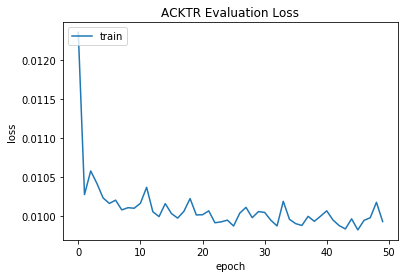

<Figure size 432x288 with 0 Axes>

In [6]:
# Do the supervised learning

def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))


num_samples = final_states.shape[0]*final_states.shape[1]
pos = torch.sum(final_states)
neg = num_samples - pos
class_weights = [pos/num_samples,neg/num_samples] 

loss = lambda output, target:  weighted_binary_cross_entropy(output, target, weights = class_weights)

# Define and train the feedforward network

es_model = nn.Sequential(
    nn.Linear(8,24),
    nn.ReLU(),
    nn.Linear(24,24),
    nn.ReLU(),
    nn.Linear(24,1),
    nn.Sigmoid()
)

state_train = init_states.reshape(-1,myenv.observation_space.shape[0]+1)
state_min = torch.min(state_train, dim=0)[0]
state_max = torch.max(state_train, dim=0)[0]

state_train_normal = ((state_train - state_min)/state_max)


#final_state_train = final_states.reshape(-1,myenv.observation_space.shape[0])
final_state_train = final_states.reshape(-1,1)

loss_hist = fit_model(es_model, state_train_normal, final_state_train, num_epochs=50, learning_rate=1e-2, loss_fn=torch.nn.BCELoss(), shuffle=True)

plt.plot(loss_hist)
plt.title('ACKTR Evaluation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure()

In [ ]:
#plt.plot(abs(np.sum(actual_final_state, axis=1) - np.sum(pred_final_state,axis=1)))

#plt.figure()

plt.plot(abs(actual_final_state[:,0] - pred_final_state.T.squeeze()))
#plt.legend(['rg', 'thg', 'thw', 'dx', 'dy', 'dthb', 'dthg'])

In [34]:
# Analyze the agility of our policy network with a simple grid search thing

r_min = .1; r_max = 5; num_r = 10
r_vals = np.linspace(r_min, r_max, num_r)

th_min = 0; th_max = 2*pi; num_th = 20
th_vals = np.linspace(th_min, th_max, num_th)

t_min = 25; t_max=250; num_t = 10;
t_vals = np.linspace(t_min, t_max, num_t, dtype=np.int)

goal_ach = np.zeros((r_vals.size, th_vals.size, t_vals.size))
pred_ach = np.zeros((r_vals.size, th_vals.size, t_vals.size))
s_pred_ach = np.zeros((r_vals.size, th_vals.size, t_vals.size))


myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps = 250


for ri,r in enumerate(tqdm.tqdm(r_vals)):
    for thi,th in enumerate(th_vals):
        
        action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
        state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
        reward_hist = np.zeros((myenv.num_steps, 1))

        obs = env.reset()
          
        x_goal = r*np.cos(th)
        y_goal = r*np.sin(th)
            
        myenv.goal = [x_goal,y_goal,.1]
        #myenv.goal = [1.8209177347168357, -1.6828028606611047, 0.1]
        #myenv.goal  = [1.8373192126473523, -0.9243333822434766, 0.1]



        for it, t in enumerate(t_vals):
            net_input = torch.cat((torch.tensor(obs).squeeze(), torch.tensor(t,dtype=torch.float32).view(1)))
            net_input = (net_input - state_min)/state_max
            if es_model(net_input) > .5:
                pred_ach[ri,thi,it] = 1
                
            s_pred_ach[ri,thi,it] = clf.predict(net_input.numpy().reshape(1,-1))
           # net_input.numpy().

            
        for i in range(myenv.num_steps):
                actions, _, _, _ = model.step(obs)
                obs, reward, done, _ = env.step(actions)        
                action_hist[i,:] = np.copy(actions)
                state_hist[i,:] = np.copy(obs)
                reward_hist[i,:] = np.copy(reward)
                #env.render()
                if done:
                    break
                    
        for it, t in enumerate(t_vals):
            if state_hist[t-1,0] == 0:
                goal_ach[ri,thi,it] = 1  
                    
       # eps_end = np.max(np.nonzero(state_hist[:,1]))

        
       


100%|██████████| 10/10 [02:53<00:00, 19.91s/it]

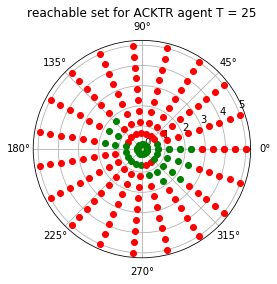

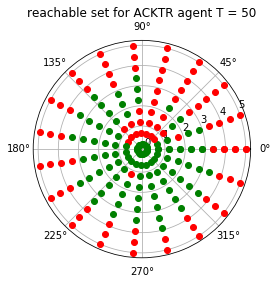

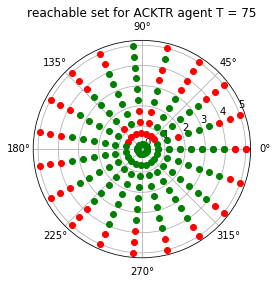

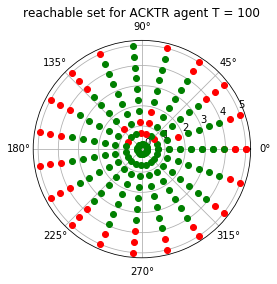

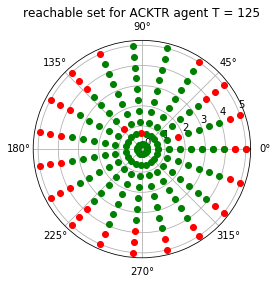

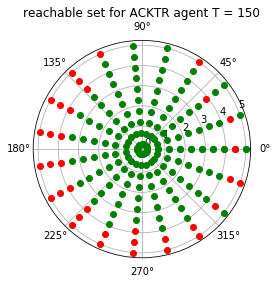

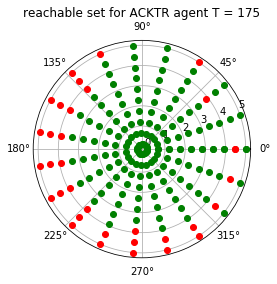

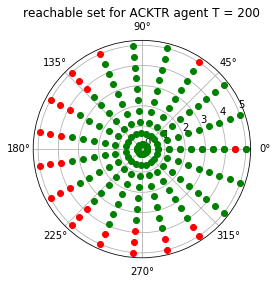

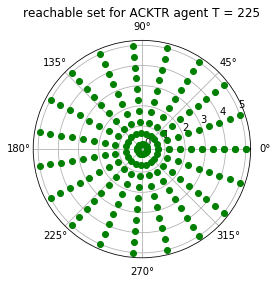

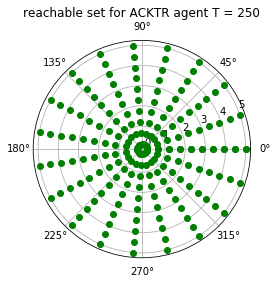

<Figure size 432x288 with 0 Axes>

In [11]:
for it, t in enumerate(t_vals):
    for i,ival in enumerate(goal_ach[:,:,it]):
        for j,val in enumerate(ival):
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')


    title = 'reachable set for ACKTR agent T = '  +  str(t)
    plt.title(title ,y=1.08)
    plt.figure()

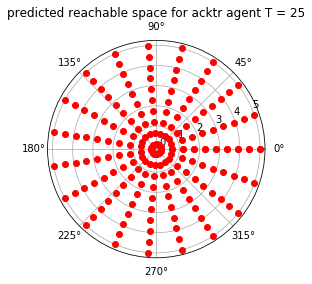

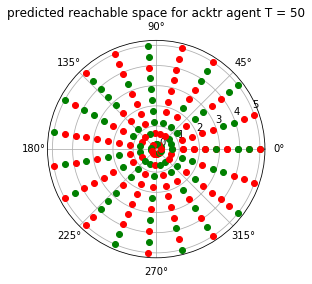

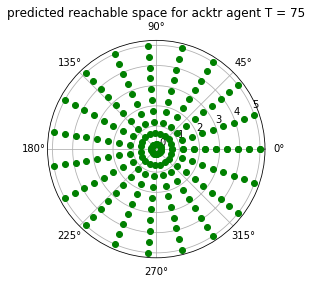

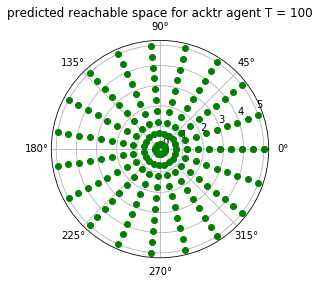

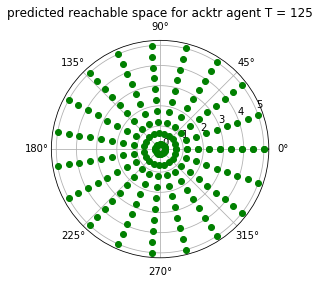

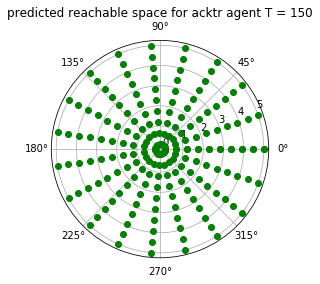

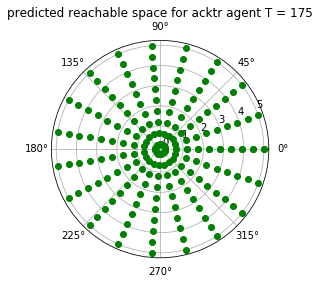

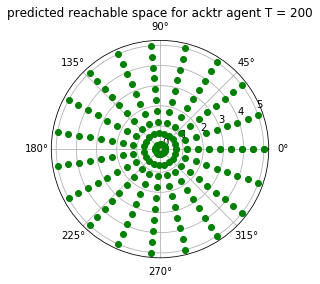

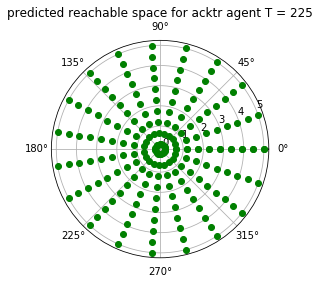

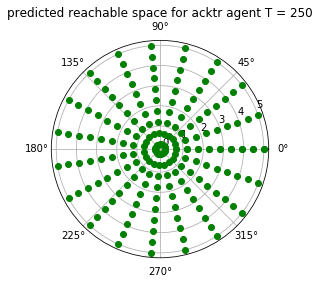

<Figure size 432x288 with 0 Axes>

In [12]:
for it, t in enumerate(t_vals):

    for i,ival in enumerate(pred_ach[:,:,it]):
        for j,val in enumerate(ival):
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')
                
        


    title = 'predicted reachable space for acktr agent T = '  +  str(t)
    plt.title(title ,y=1.08)
    plt.figure()

In [23]:
from sklearn import svm
Y = final_state_train.numpy().squeeze()
X = state_train.numpy()

clf = svm.SVC()
clf.fit(X, Y)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
clf.predict(net_input.numpy().reshape(1,-1))

array([1.], dtype=float32)

In [38]:
np.sum(Y)

1865.0

In [39]:
Y.shape

(2500,)

Text(0.5, 0, 'epoch')

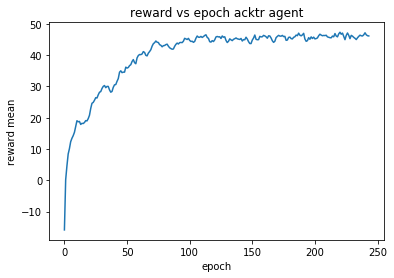

In [5]:
plt.plot(t_data['eprewmean'])
plt.title('reward vs epoch acktr agent')
plt.ylabel('reward mean')
plt.xlabel('epoch')